In [1]:
using Plots
using Statistics
using Unitful: ms, s, Hz, Time, uconvert
using DifferentialEquations

In [31]:
#=== Setup ===#

const halfheight = 0.4;
function plot_spikes(spikes::BitArray{2}, scale::Time; kw...)
    trials = size(spikes)[2]
    rasterplot = plot(trials;
        xlabel="Time",
        xformatter=x->uconvert(s, x*scale),
        leg=false,
        yticks=nothing,
        linecolor="black",
        kw...)
    for i in 1:trials
        for j in 1:size(spikes)[1]
            if spikes[j, i]
                append!(rasterplot, i, Float64[NaN, j, j], Float64[NaN, i + halfheight, i - halfheight])
            end
        end
    end
    return rasterplot
end

function plot_spikes(spikes::BitArray{1}, scale::Time; kw...)
    return plot_spikes(BitArray(reshape(spikes, :, 1)), scale; kw...)
end

function generate_spikes(duration::Time, Δt::Time, r_est::Function, trials::Int=1; refractory_period::Bool=false)
    bins = convert(Int64, duration/Δt)
    if refractory_period
        xrand = rand(Float64, bins, trials)
        recording = BitArray{2}(undef, (bins, trials))
        for trial in 1:trials
            last_spike = 0ms
            for bin in 1:bins
                spike = (r_est(bin * Δt, last_spike) * Δt) > xrand[bin, trial]
                recording[bin, trial] = spike
                if spike
                    last_spike = bin * Δt
                end
            end
        end
        return recording
    else
        # Figure out whether the r_est t input is in bin count or ms
        return (>).((r_est.(repeat(1:bins, 1, trials)*Δt)*Δt), rand(Float64, bins, trials))
    end
end

function count_interspike_intervals(spikes::BitArray{2})
    return map(function (spike_train)
            intervals::Array{Int} = Array{Int}[]
            count = 0
            for i in 1:length(spike_train)
                count += 1
                if spike_train[i]
                    push!(intervals, count)
                    count = 0
                end
            end
            return intervals
            end, [spikes[:, i] for i in 1:size(spikes,2)])
end

function plot_isi(interspike_intervals::Array{Int}, scale::Time; kw...)
    return histogram(interspike_intervals,
        title="Interspike Intervals",
        xlabel="Interval",
        xformatter=x->uconvert(ms, x*scale),
        ylabel="Count",
        leg=false,
        bins=100,
        kw...)
end

function coefficient_of_variation(interspike_intervals::Array{Int})
    return std(interspike_intervals)/mean(interspike_intervals)
end

function bin_train(spikes::BitArray{1}, interval::Time, Δt::Time)
    binsize = convert(Int, interval / Δt)
    bins = Int(length(spikes)/binsize)
    return [sum(spikes[i*binsize+1:(i+1)*binsize]) for i in 0:bins-1]
end

function fano_factor(spikes::BitArray{1}, interval::Time, Δt::Time)
    groups = bin_train(spikes, interval, Δt)
    return var(groups)/mean(groups)
end

function fano_factor(spikes::BitArray{2}, interval::Time, Δt::Time)
    fano_factor(BitArray{1}(reshape(spikes, :)), interval, Δt)
end

function spike_autocorrelation(spikes::BitArray{1}, Δt::Time, window::Time, bin_interval::Time=1ms)
    groups = bin_train(spikes, bin_interval, Δt)
    return [sum([groups[j] * groups[j+i] for j in 1:(length(groups)-i)]) for i in 1:(window ÷ bin_interval)]
end

function spike_autocorrelation_histogram(spikes::BitArray{1}, Δt::Time, window::Time, bin_interval::Time=1ms; kw...)
    correlation = autocorrelation(spikes, Δt, window, bin_interval)
    return plot(correlation,
        seriestype=:bar,
        xlabel="Time",
        x=x->uconvert(ms, x*bin_interval),
        yaxis=false,
        leg=false,
        bins=length(correlation);
        kw...)
end

spike_autocorrelation_histogram (generic function with 2 methods)

1. Generate spikes for 10 s (or longer if you want better statistics) using a Poisson spike generator with a constant rate of 100 Hz, and record their times of occurrence. Compute the coeÆcient of variation of the interspike intervals, and the Fano factor for spike counts obtained over counting intervals ranging from 1 to 100 ms. Plot the interspike interval histogram.

FF (W=1

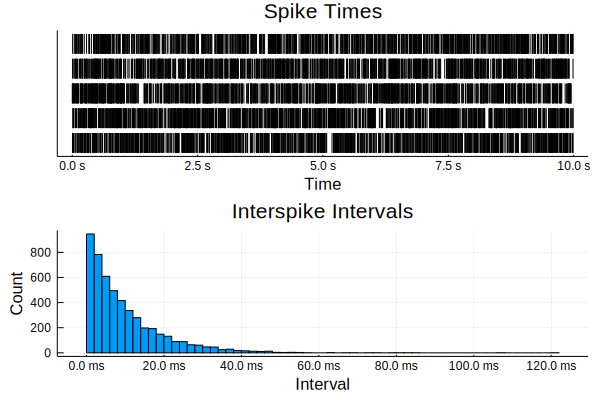

 ms): 0.9973165501045869
FF (W=5 ms): 1.0164588785922613
FF (W=10 ms): 1.0278099645086256
FF (W=20 ms): 1.0359691046229813
FF (W=50 ms): 1.084074640678414
FF (W=100 ms): 1.1387775551102204
Cv: 1.016986745529862


In [3]:
#=== Problem 1 ===#
Δt = 0.1ms
spikes = generate_spikes(10s, Δt, t->100Hz, 5)
interspike_intervals = vcat(count_interspike_intervals(spikes)...)

fano_intervals = [1ms, 5ms, 10ms, 20ms, 50ms, 100ms]
fano_factors = map(interval->fano_factor(spikes, interval, Δt), fano_intervals)
for i in 1:length(fano_intervals)
    println("FF (W=", fano_intervals[i], "): ", fano_factors[i])
end

display(plot(plot_spikes(spikes, Δt, title="Spike Times"), plot_isi(interspike_intervals, Δt), layout=(2,1)))
println("Cv: ", coefficient_of_variation(interspike_intervals))

2. Add a refractory period to the Poisson spike generator by allowing the firing rate to depend on time. Initially, set the firing rate to a constant value $r(t) = r_0$. After every spike, set $r(t)$ to 0, and then allow it to recover exponentially back to $r_0$ with a time constant τref that controls the refractory recovery rate. In other words, have $r(t)$ obey the equation $$\tau_{\text{ref}} \frac{dr}{dt} = r_0 - r$$ except immediately after a spike, when it is set to 0. Plot the coefficient of variation as a function of $\tau_{\text{ref}}$ over the range 1 ms $\leq \tau_{\text{ref}} \leq$ 20 ms and plot interspike interval histograms for a few different values of $\tau_{\text{ref}}$ in this range. Compute the Fano factor for spike counts obtained over counting intervals ranging from 1 to 100 ms for the case $\tau_{\text{ref}} =$ 10ms.

In [21]:
#=== Problem 2 ===#
duration = 10.0s
r0 = 100.0Hz
τrefs = 1.0ms:1.0ms:20.0ms
time_span = (0.0s, 10.0s)

# Generate spike trains
spikes = Vector{BitArray{2}}(undef, length(τrefs))
ISIs = Vector{Array{Int}}(undef, length(τrefs))
Cvs = Vector{Float64}(undef, length(τrefs))
# TODO: turn into function, parameterize τrefs

function refractory_rate_function(τref)
    solution = solve(ODEProblem((r, p, t)->((r0 - r)/(p[1])), 0.0Hz, (0.0s, duration), [τref]))
    return (t, last_spike) -> solution(t-last_spike)
end

for i in 1:length(τrefs)
    spikes[i] = generate_spikes(duration, Δt, refractory_rate_function(τrefs[i]); refractory_period=true)
    ISIs[i] = vcat(count_interspike_intervals(spikes[i])...)
    Cvs[i] = coefficient_of_variation(ISIs[i])
end

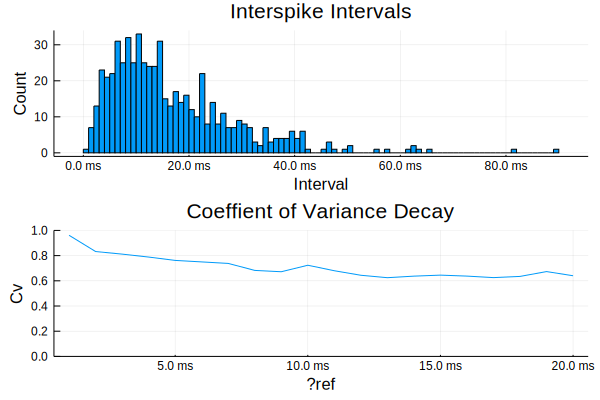

FF (W=1 ms): 0.9438500897069564
FF (W=5 ms): 0.7661414599917402
FF (W=10 ms): 0.6731295053442695
FF (W=20 ms): 0.6213231832793104
FF (W=50 ms): 0.5765741458972716
FF (W=100 ms): 0.5115585384041761


In [5]:
# Analyze spike trains
ISI_plot = plot_isi(ISIs[10], Δt)
Cv_plot = plot(τrefs, Cvs;
    title="Coeffient of Variance Decay",
    xlabel="τref",
    xformatter=x->x*1ms,
    ylabel="Cv",
    ylims=(0.0,1.0),
    leg=false)

fano_intervals = [1ms, 5ms, 10ms, 20ms, 50ms, 100ms]
fano_factors = map(interval->fano_factor(spikes[10], interval, Δt), fano_intervals)
for i in 1:length(fano_intervals)
    println("FF (W=", fano_intervals[i], "): ", fano_factors[i])
end

display(plot(ISI_plot, Cv_plot, layout=(2,1)))

3. Compute autocorrelation histograms of spike trains generated by a Poisson generator with a constant firing rate of 100 Hz, a constant firing rate of 100 Hz together with a refractory period modeled as in exercise 2 with $\tau_{\text{ref}} =$ 10 ms, and a variable firing rate $r(t) = 100(1 + \cos(2\pi t / 25 \text{ms})) \text{Hz}$. Plot the histograms over a range from 0 to 100 ms.

In [29]:
#=== Problem 3 ===#
# Generate spiketrains
constant_generator_spikes   = dropdims(generate_spikes(30s, Δt, t->100Hz), dims=(2));
refractory_generator_spikes = dropdims(generate_spikes(30s, Δt, refractory_rate_function(10.0ms);
                                              refractory_period=true), dims=(2));
variable_firing_spikes      = dropdims(generate_spikes(30s, Δt, t->(100Hz * (1 + cos(2π*t/25ms)))), dims=(2));

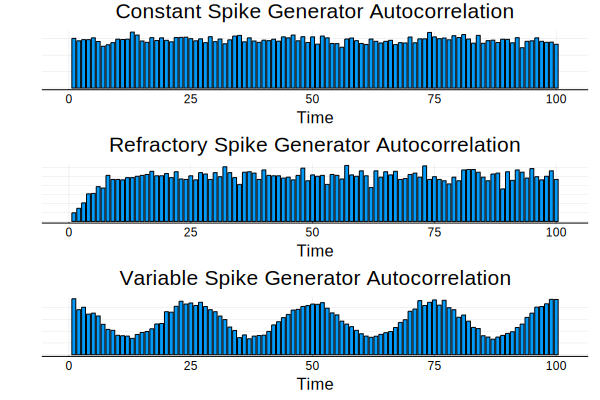

In [32]:
display(plot(
        spike_autocorrelation_histogram(constant_generator_spikes, Δt, 100ms;
            title="Constant Spike Generator Autocorrelation"),
        spike_autocorrelation_histogram(refractory_generator_spikes, Δt, 100ms;
            title="Refractory Spike Generator Autocorrelation"),
        spike_autocorrelation_histogram(variable_firing_spikes, Δt, 100ms;
            title="Variable Spike Generator Autocorrelation"), layout=(3,1)))


4. Generate a Poisson spike train with a time-dependent firing rate $r(t) = 100(1 + \cos(2\pi t / 25 \text{ms})) \text{Hz}$. Approximate the firing rate from this spike train using a variable $\text{r}_{\text{approx}}$ that satisfies $$\tau_{\text{approx}} \frac{d\text{r}_{\text{approx}}}{dt} = -\text{r}_{\text{approx}}$$ except that $\text{r}_{\text{approx}} \rightarrow \text{r}_{\text{approx}} + 1/\tau_{\text{approx}}$ every time a spike occurs. Make plots of the true rate, the spike sequence generated, and the estimated rate. Experiment with a few different values of $\tau_{\text{approx}}$ in the range of 1 to 100ms. Determine the best value of $\tau_{\text{approx}}$ by computing the average squared error of the estimate, $\int dt(\text{r}(t)- \text{r}_{\text{approx}}(t))^2$, for different values of $\tau_{\text{approx}}$, and finding the value of $\tau_{\text{approx}}$ that minimizes the error.

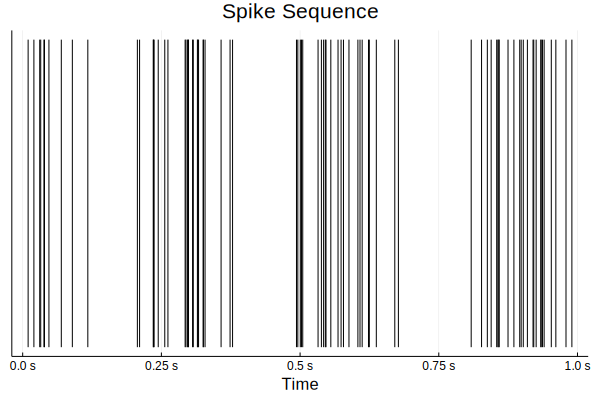

Best τapprox value = 29.0 ms


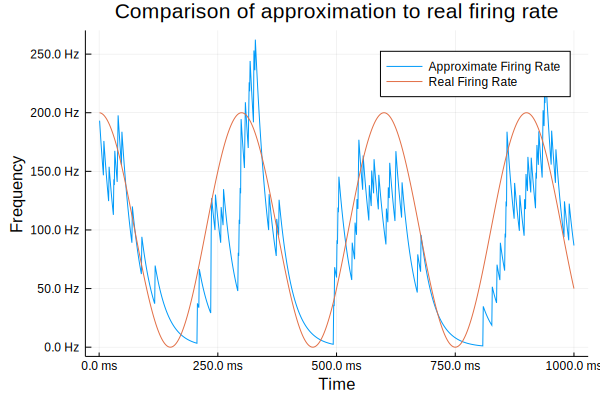

In [8]:
#=== Problem 4 ===#
duration = 1.0s
r(t::Time) = 100Hz * (1 + cos(2π * t / 300ms))
spikes = dropdims(generate_spikes(duration, Δt, r), dims=(2))
spike_plot = plot_spikes(spikes, Δt, title="Spike Sequence")

function solve_approximation(τapprox)
    problem = ODEProblem(
        (r, p, t)->((-r)/(p[1])),
        200.0Hz,
        (0.0ms, length(spikes)*Δt),
        Tuple(τapprox))
    affect!(integrator) = integrator.u += 1/(integrator.p[1])
    
    spike_times = findall(identity, spikes) * Δt
    callback = DiscreteCallback((u, t, integrator) -> t ∈ spike_times, affect!)
    return solve(problem, Tsit5(), callback=callback, tstops=spike_times)
end

function average_square_error(truth, approximation, values)
    return mean([(truth(value) - approximation(value))^2 for value in values])
end


display(plot(spike_plot))
test_range = 1.0ms:1.0ms:100.0ms
best_τ = (test_range)[argmin(map(τ->average_square_error(r, solve_approximation(τ), 1.0ms:1.0ms:duration), test_range))]
println("Best τapprox value = ", best_τ)
plot(1:1000,
    [x->solve_approximation(best_τ)(x*1.0ms).val, x->r(x*1.0ms).val],
    title="Comparison of approximation to real firing rate",
    label=["Approximate Firing Rate" "Real Firing Rate"],
    xformatter=x->x*1.0ms,
    xlabel="Time",
    yformatter=y->y*1.0Hz,
    ylabel="Frequency"
)

6. Build an approximate white-noise stimulus by choosing random values at discrete times separated by a time-step interval $\Delta t$. Plot its autocorrelation function and power spectrum (use the Matlab funcion `spectrum` or  `psd`). Discuss how well this stimulus matches an ideal white-noise stimulus given the value of $\Delta t$ you used.

In [28]:
#=== Problem 6 ===#
white_noise_stimulus(duration::Time, Δt::Time, amp=1.0) = rand((-amp, amp), convert(Int, duration/Δt))
stimulus_autocorrelation(stimulus) = [mean([stimulus[j] * stimulus[j+i] for j in 1:(length(stimulus)-i)]) for i in 0:(length(stimulus)-1)]

noise = white_noise_stimulus(10.0s, 1.0ms)
Qss = stimulus_autocorrelation(noise)
plot(Qss, seriestype=:bar, xlabel="τ", leg=false)